In [2]:
import plotly.express as px
import pandas as pd

In [4]:
# The input file consists of lines with the starting position and velocity of a hailstone:
#  '197869613734967, 292946034245705, 309220804687650 @ 150, 5, -8'
#
# Parse them and turn them into a list of pairs of lists:
#
#   ([197869613734967, 292946034245705, 309220804687650], [150, 5, -8]) 
#

def parse_coords(s):
    return [int(x) for x in s.split()]
    
def parse_input_line(line):
    sides = line.replace(",", "").split("@")
    return (parse_coords(sides[0]), parse_coords(sides[1]))
    
def read_input_file():
    with open("input.txt") as f:
        input_text = f.read()
    input_lines = input_text.splitlines()
    hail_lines = input_lines[1:]
    return [parse_input_line(line) for line in hail_lines]

hails = read_input_file() 
hails[0:5]

[([197869613734967, 292946034245705, 309220804687650], [150, 5, -8]),
 ([344503265587754, 394181872935272, 376338710786779], [-69, 11, -46]),
 ([293577250654200, 176398758803665, 272206447651388], [-17, 101, 26]),
 ([227838629808858, 367321356713508, 425398385268402], [65, 16, -116]),
 ([297081053375721, 388848043410867, 296378505058047], [-18, -39, 33])]

In [13]:
# Turn `hails` into a DataFrame with these columns:
#   id : unique id for each hailstone 
#   x : x coordinate 
#   y : y coordinate 
#   z : z coordinate 
#
# Each hailstone has two entries: the starting point, and its travel as far as 0 or 50_000_000_000_000 on any axis.
#

def num_ticks(pos_and_vel):
    (p, v) = pos_and_vel
    if v < 0:
        ticks = p // (-v)
    else:
        ticks = (50_000_000_000_000 - p) // v
    return max(ticks, 1)

def make_data_frame(entries): 
    records = [] 
    i = 0
    for ([x, y, z], [vx, vy, vz]) in entries:
        ticks = min(num_ticks(p_and_v) for p_and_v in zip([x, y, z], [vx, vy, vz]))
        records.append(dict(id=i, x=x, y=y, z=z))
        records.append(dict(id=i, x=(x + vx*ticks), y=(y + vy*ticks), z=(z + vz*ticks)))
        i = i + 1
    return pd.DataFrame.from_records(records)

# My browser (Safari) hangs with 200 of them, so just showing 100.
hail = make_data_frame(hails[:100])
hail

,id,x,y,z
0,0,197869613734967,292946034245705,309220804687650
1,0,197869613735117,292946034245710,309220804687642
2,1,344503265587754,394181872935272,376338710786779
3,1,344503265587685,394181872935283,376338710786733
4,2,293577250654200,176398758803665,272206447651388
...,...,...,...,...
195,97,281337106418170,131556887203662,394376757970699
196,98,330503962382908,330818974149580,537427943951777
197,98,330503962382850,330818974149635,537427943951522
198,99,283277882485918,140980016640358,250970251275309


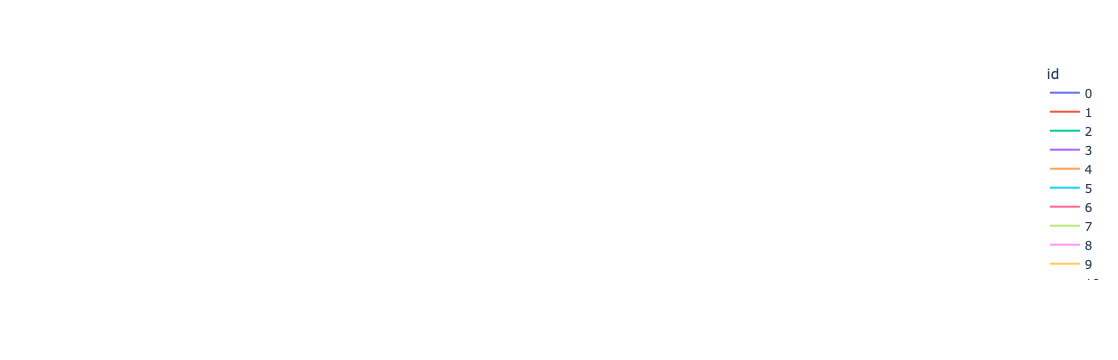

In [14]:
fig = px.line_3d(hail, x="x", y="y", z="z", color="id")
fig.show()